# Cosine Similarity

---

*Features*

- words

*Results*

- more words

*Decision*

- maybe words

### Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-10


### Load Data

In [2]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("..","data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### Bag-of-Upto-Bigrams with 2,000 terms


In [3]:
import cleanup_module as Cmod
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

dtm_pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=2)),
                     ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=2000))
                    ])

X_train_bow = dtm_pipe.fit_transform(X_train)

### SVD 

In [23]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import MinMaxScaler

def perform_SVD(X, n_topics=300):
    X_array = X.asfptype()
    U, Sigma, VT = svds(X_array.T, k=n_topics)
    # reverse outputs
    Sigma = Sigma[::-1]
    U, VT = svd_flip(U[:, ::-1], VT[::-1])
    # return V (for now)
    V = VT.T
    return V

X_train_svd = perform_SVD(X_train_bow)

# scale for precision/recall calcs
#scaler = MinMaxScaler()
#X_train_svd_scaled = scaler.fit_transform(X_train_svd)

# sparse
X_train_svd_scaled = sp.csr_matrix(X_train_svd_scaled)

### Calculate Spam Cosine Similarity

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

# no need to transpose as in R
X_cossim_svd = cosine_similarity(X_train_svd_scaled)
X_cossim_bow = cosine_similarity(X_train_bow)

In [26]:
# check that it is the 3900 documents that are being compared
# not the 300 or 2000 features
X_cossim_svd.shape, X_cossim_bow.shape

In [27]:
data = {'sms':X_train, 'target':y_train}
train_df = pd.DataFrame(data)
train_df.head()

In [50]:
# get spam indexes
spam_ix = train_df.loc[train_df['target']=='spam'].index

In [52]:
# calculate average spam similarity
mean_spam_sims = []
for ix in range(X_cossim_svd.shape[0]):
    mean_spam_sims.append(np.mean(X_cossim_svd[ix, spam_ix]))

### Visualize 

In [53]:
# df for plot
data = {'sims':mean_spam_sims, 'target':y_train}
spam_sim_df = pd.DataFrame(data)

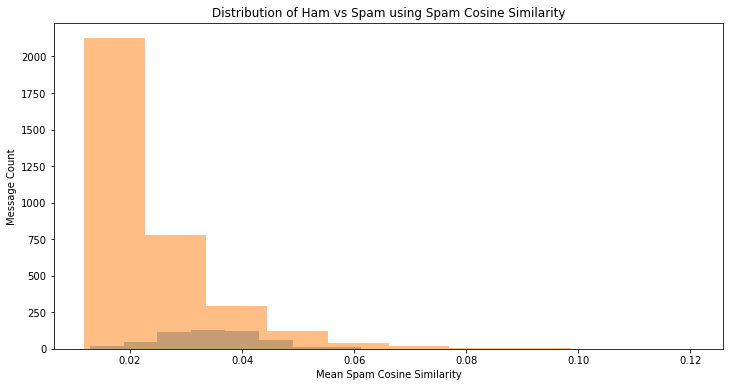

In [54]:
import matplotlib.pyplot as plt 

spamhist = spam_sim_df.loc[spam_sim_df['target']=='spam']['sims']
hamhist = spam_sim_df.loc[spam_sim_df['target']=='ham']['sims']

plt.figure(figsize=(12,6))
plt.hist(1-spamhist, alpha=0.5)
plt.hist(1-hamhist, alpha=0.5)
plt.title('Distribution of Ham vs Spam using Spam Cosine Similarity')
plt.ylabel('Message Count')
plt.xlabel('Mean Spam Cosine Similarity')
plt.show()

In [24]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 0 m 30 s


---